In [112]:
import numpy as np
import os
from matplotlib import pyplot as plt
from astropy.io import fits
# from astropy import stats
# import shutil
from astropy.visualization import simple_norm

from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.ndimage import shift
from matplotlib.colors import LogNorm

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astroquery.ned import Ned
import astropy.units as u
from astropy.nddata import Cutout2D
# import pylab as plt
from scipy import interpolate
from matplotlib.colors import ListedColormap
# import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output
# from pyBBarolo import *
from scipy import stats

In [113]:
# Filling NaN pixels with the values of pixels located symmetrically relative to the major axis.
# It is a necessary procedure if we want to obtain reliable results from the Barolo application.

def fill_nans(fits_file=None,galname=None,cvel=None,savefits=False,show_plot=False):
    
    RA = Ned.query_object(galname)['RA']
    DEC = Ned.query_object(galname)['DEC']
    print(RA, DEC)

    cposition = SkyCoord('{} {}'.format(RA[0],DEC[0]), frame='fk5', unit='deg', equinox='J2000.0')
    data =  WCS(fits_file, naxis = 2)

    print(cposition)
    y0_,x0_ = skycoord_to_pixel(cposition,data) #find central pixel
    y0_,x0_ = int(y0_),int(x0_)
    
    maps = fits.getdata(fits_file)
    maps_ = np.squeeze(maps)
    maps = maps_-cvel
    maps = maps.T
    X,Y = np.meshgrid(np.arange(0,maps.shape[1], 1), np.arange(0,maps.shape[0], 1))

    R_max = np.min([x0_,maps.shape[1]-x0_,y0_,maps.shape[0]-y0_])
    nan_map = np.isnan(maps) & (np.abs(X-x0_) < R_max) & (np.abs(Y-y0_) < R_max)

    nan_X = X[nan_map]
    nan_Y = Y[nan_map]

    maps_new = maps*1.0
    maps_new[nan_Y, nan_X] = - maps[2*y0_-nan_Y,2*x0_-nan_X]

    if show_plot:
        fig = plt.figure(figsize=[21,9])
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        X, Y = np.meshgrid(np.arange(0, maps.shape[1], 1), np.arange(0, maps.shape[0], 1))    

        plt.subplot(1,2,1) 
        plt.title(r'$V_{obs}$', fontsize=35, pad=20)
        quadmesh = plt.pcolormesh(X,Y, maps, cmap='coolwarm')
        quadmesh.set_clim(vmin=-150,vmax=150)
        plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False)
        plt.colorbar()

        plt.subplot(1,2,2) 
        plt.title(r'$V_{obs}$ fill Nan', fontsize=35, pad=20)
        quadmesh = plt.pcolormesh(X,Y, maps_new, cmap='coolwarm')
        # quadmesh = plt.pcolormesh(X,Y, maps_new.T, cmap='coolwarm')
        quadmesh.set_clim(vmin=-150,vmax=150)
        plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False)
        plt.colorbar()
    
    if savefits:
        
        data = fits.open(fits_file)
        header = data[0].header
        fits_new = fits.PrimaryHDU(data=np.array(maps_new.T+cvel),header=header)
        fits_new.writeto(fits_file.replace('.fits','_notnan.fits'),overwrite=True)
    

    RA    
 degrees  
----------
  65.00164    DEC    
 degrees  
----------
 -54.93794
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (65.00164, -54.93794)>


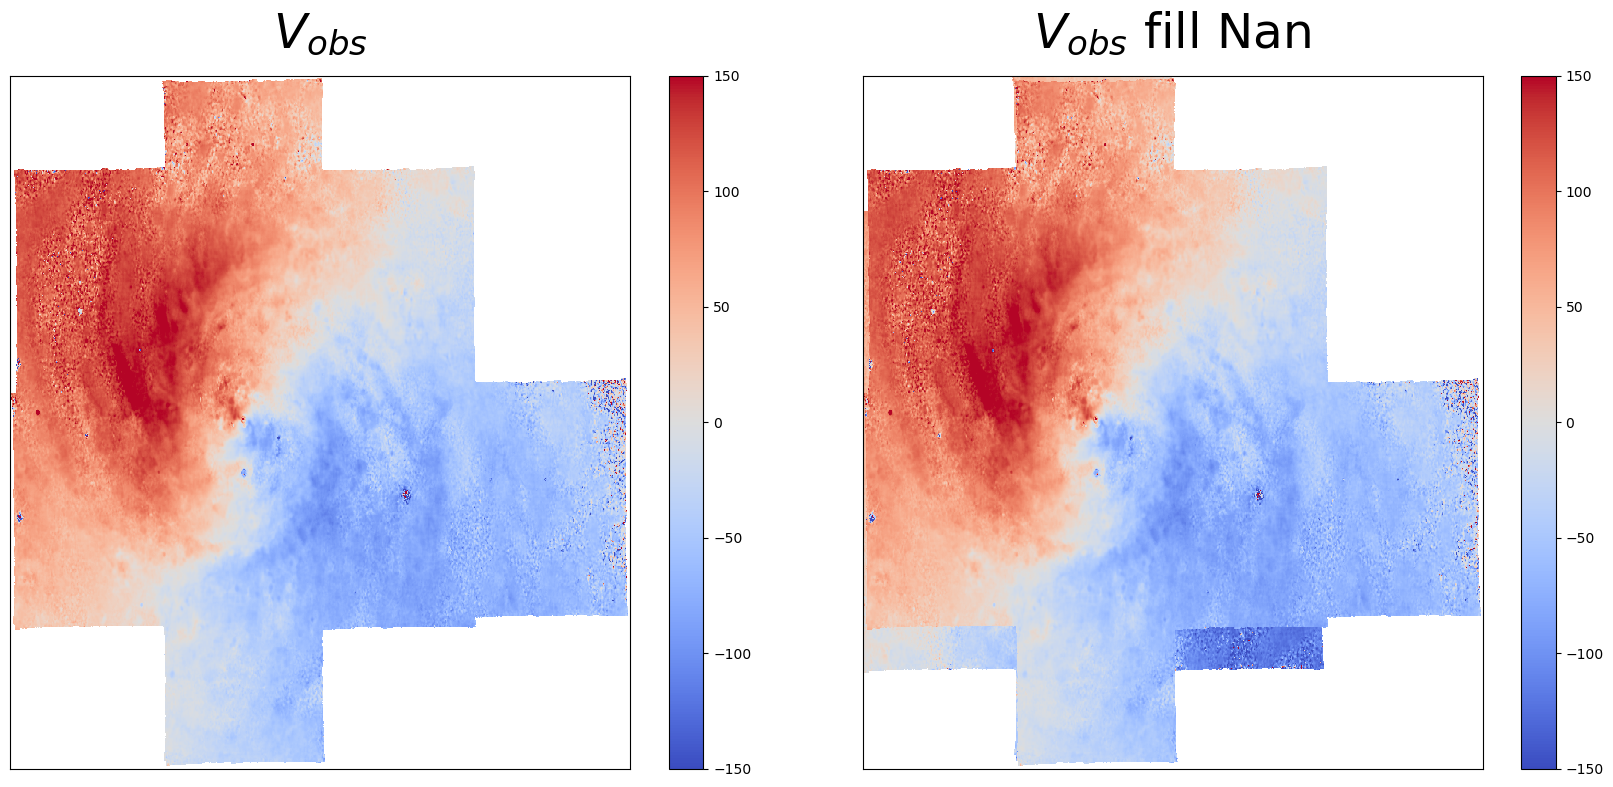

In [114]:
fill_nans(fits_file='./data/NGC1566_vel_Ha.fits',cvel = 0, galname='NGC1566',savefits=True,show_plot=True)

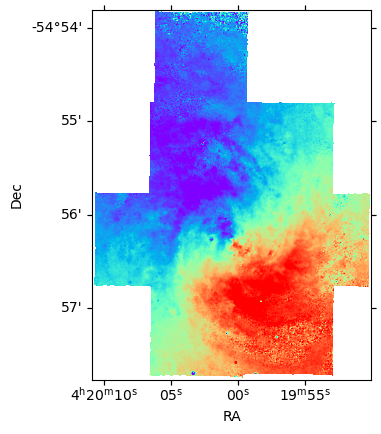

In [115]:
import warnings
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS, FITSFixedWarning
from astropy.utils.data import get_pkg_data_filename

filename = get_pkg_data_filename('./data/NGC1566_vel_Ha.fits')

hdu = fits.open(filename)[0]
with warnings.catch_warnings():
    # Ignore a warning on using DATE-OBS in place of MJD-OBS
    warnings.filterwarnings('ignore', message="'datfix' made the change",
                            category=FITSFixedWarning)
    wcs = WCS(hdu.header)

fig = plt.figure()
fig.add_subplot(111, projection=wcs)
norm = simple_norm(hdu.data, "linear", percent=95)
plt.imshow(hdu.data, cmap="rainbow", origin="lower", norm=norm)
# plt.imshow(hdu.data, origin='lower', cmap="rainbow", norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')

In [116]:
wcs_coord = np.empty(shape=(hdu.data.shape[0],hdu.data.shape[1], 2))
print(wcs_coord.shape)

(1187, 898, 2)


In [117]:

print(wcs.pixel_to_world(30, 40))

<SkyCoord (ICRS): (ra, dec) in deg
    (65.0425075, -54.96047854)>


In [118]:
for i in range(wcs_coord.shape[0]):
    for j in range(wcs_coord.shape[1]):
        wcs_coord[i, j] = wcs.wcs_pix2world(i, j, 1)
        

In [119]:
wcs_coord.shape

(1187, 898, 2)

In [120]:
wcs_coord[:,:,0]

array([[65.04550962, 65.04550956, 65.0455095 , ..., 65.04545566,
        65.0454556 , 65.04545554],
       [65.04541285, 65.04541279, 65.04541273, ..., 65.04535901,
        65.04535895, 65.04535889],
       [65.04531608, 65.04531602, 65.04531596, ..., 65.04526236,
        65.04526231, 65.04526225],
       ...,
       [64.93093594, 64.93093604, 64.93093613, ..., 64.93102357,
        64.93102366, 64.93102376],
       [64.93083917, 64.93083927, 64.93083937, ..., 64.93092692,
        64.93092701, 64.93092711],
       [64.9307424 , 64.9307425 , 64.9307426 , ..., 64.93083027,
        64.93083037, 64.93083046]])

In [121]:
print(wcs_coord.shape)
galname = "NGC1566"
# RA = np.asarray(Ned.query_object(galname)['RA'])
# DEC = np.asarray(Ned.query_object(galname)['DEC'])

RA0, DEC0 = wcs.wcs_pix2world(hdu.header["CRPIX1"], hdu.header["CRPIX2"], 1)
print(RA0, DEC0)
# print(RA, DEC)

(1187, 898, 2)
65.001846393711 -54.93791205151501


C:\Users\kpoli\AppData\Local\Temp\ipykernel_9628\320712562.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(3600*(wcs_coord[:,:,0]-RA0), 3600*(wcs_coord[:,:,1]-DEC0), hdu.data)


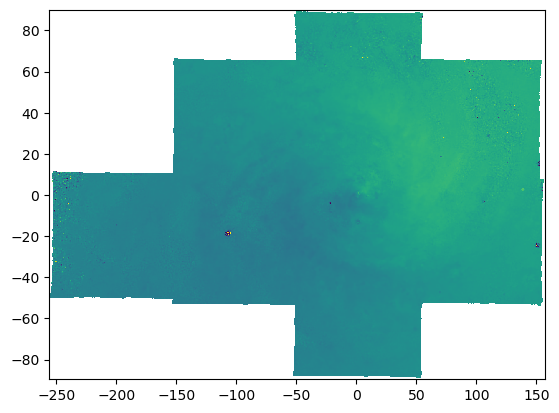

In [122]:
plt.close()
plt.pcolormesh(3600*(wcs_coord[:,:,0]-RA0), 3600*(wcs_coord[:,:,1]-DEC0), hdu.data)
plt.show()

C:\Users\kpoli\AppData\Local\Temp\ipykernel_9628\4205306102.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = plt.pcolormesh(x, y, np.sqrt(x**2 + y**2))


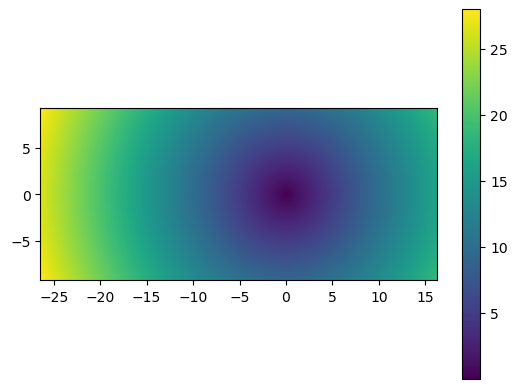

In [ ]:
dist = 21.3 * 1000 
plt.close()
x = dist*np.tan((wcs_coord[:,:,0]-RA0)/180*np.pi)
y = dist*np.tan((wcs_coord[:,:,1]-DEC0)/180*np.pi)
# plt.pcolormesh(x, y, hdu.data, norm=norm)
# plt.imshow(np.sqrt(x**2 + y**2))
im = plt.pcolormesh(x, y, np.sqrt(x**2 + y**2))
# plt.contour(x, y, np.sqrt(x**2 + y**2))
plt.colorbar(im)
plt.axis('scaled')
plt.show()

In [124]:
print(np.asarray(np.sqrt(x**2 + y**2)).shape)

(1187, 898)


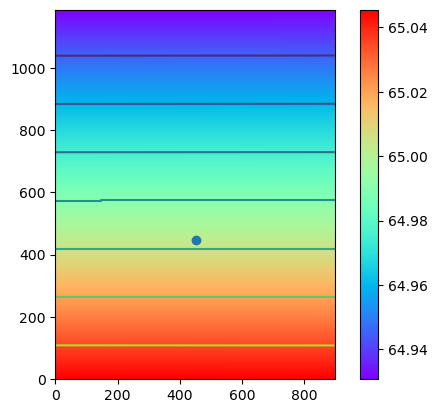

In [125]:
plt.close()
im = plt.imshow(wcs_coord[:,:,0], origin="lower", cmap="rainbow")
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.contour(wcs_coord[:, :, 0])
plt.colorbar(im)
plt.show()

In [126]:
wcs_coord[:,:, 0] = wcs_coord[:, :, 0] - RA0
wcs_coord[:,:, 1] = wcs_coord[:, :, 1] - DEC0

In [127]:
# print(wcs_coord)

In [155]:
distance_map = np.empty(shape=hdu.data.shape)
distance_map_pix = np.empty(shape=hdu.data.shape)
print(distance_map.shape)

(1187, 898)


In [129]:
i0 = hdu.header["CRPIX1"]
j0 = hdu.header["CRPIX2"]
print(i0, j0)

451.21399818598 447.31895706293


In [156]:
for i in range(wcs_coord.shape[0]):
    for j in range(wcs_coord.shape[1]):
        # distance_map[i, j] = np.sqrt(wcs_coord[i, j, 0]**2 + wcs_coord[i, j, 1]**2)
        distance_map_pix[i, j] = np.sqrt((i-i0)**2 + (j-j0)**2)

In [131]:
print(wcs_coord[500, 500,:])

[-0.00471768  0.00292682]


In [160]:
print(distance_map_pix[500, 500])
print(distance_map_pix[int(i0), int(j0)])

71.80087922814717
0.38409482109977455


In [161]:
# plt.subplot(121)
# im = plt.imshow(wcs_coord[:, :, 0], origin="lower", cmap="rainbow")
# plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
# plt.contour(wcs_coord[:, :, 0])
# plt.colorbar(im)

# plt.subplot(122)
# im = plt.imshow(wcs_coord[:, :, 1], origin="lower", cmap="rainbow")
# plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
# plt.contour(wcs_coord[:, :, 1])
# plt.axis('off')
# plt.colorbar(im)

# plt.show()

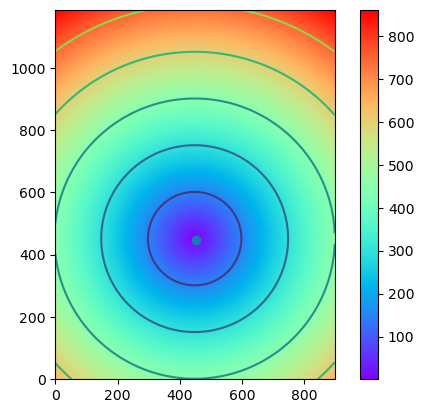

In [163]:
im = plt.imshow(distance_map_pix, origin="lower", cmap="rainbow")
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.contour(distance_map_pix)
plt.colorbar(im)
plt.show()

(1187, 898)


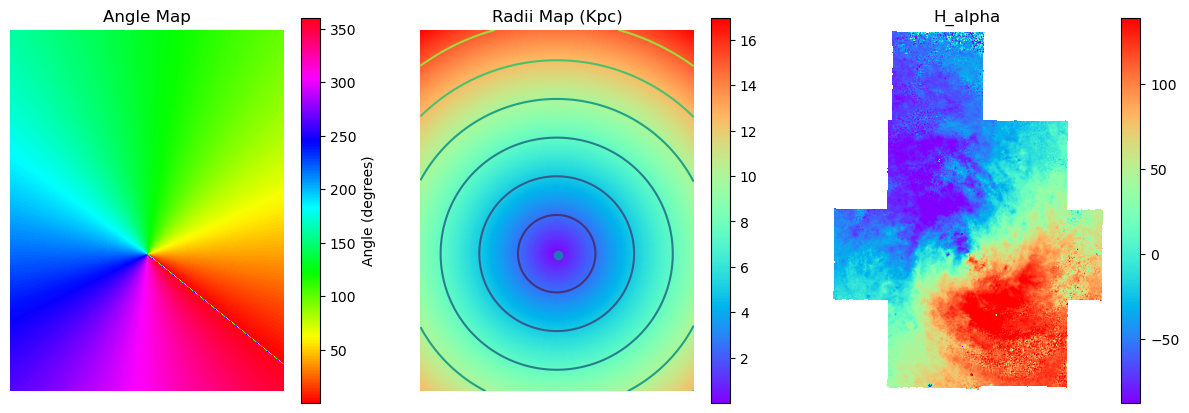

In [189]:
def create_angle_map(image_size, pa_deg, center_x, center_y):
    # Define the center of the image
    # center_x, center_y = image_size[0]//2, image_size[1]//2
    
    # Convert the position angle from degrees to radians
    pa_rad = np.radians(pa_deg)
    
    # Create a grid of coordinates for the image
    x = np.arange(image_size[1])
    y = np.arange(image_size[0])
    X, Y = np.meshgrid(x - center_x, y - center_y)  # Create coordinate grid centered at (0,0)
    
    # Calculate the angle for each pixel (in radians) relative to the center (0,0)
    angle_map = np.arctan2(Y, X)  # Angle in radians from the center
    
    # Adjust for the PA (rotate the angle to match the PA of the galaxy)
    angle_map += pa_rad - np.pi  # Apply the position angle offset
    
    # Normalize the angle to be within [0, 2π] range
    angle_map = np.mod(angle_map, 2 * np.pi)
    
    # Convert the angle map to degrees for easier interpretation
    angle_map_deg = np.degrees(angle_map)
    
    return angle_map_deg

# Parameters
shape = hdu.data.shape
print(shape)
image_size = shape
pa_deg = 219

# Create the angle map
angle_map = create_angle_map(image_size, pa_deg, hdu.header["CRPIX1"], hdu.header["CRPIX2"])

# Plot the angle map
plt.figure(figsize=[15, 5])
plt.subplot(131)
# fig.add_subplot(121, projection=wcs)
plt.imshow(angle_map, cmap='hsv', origin='lower')
plt.colorbar(label="Angle (degrees)")
plt.axis("off")
plt.title("Angle Map")

dist = 20.3 * 1000 
distance_map = dist*np.tan(np.radians(distance_map_pix*hdu.header["CD2_2"]))
# distance_map = dist*distance_map_pix*np.tan(hdu.header["CD2_2"]*np.pi/180)
plt.subplot(132)
im = plt.imshow(distance_map, origin="lower", cmap="rainbow")
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.contour(distance_map)
plt.colorbar(im)
plt.axis("off")
plt.title("Radii Map (Kpc)")

plt.subplot(133)
norm = simple_norm(hdu.data, "linear", percent=95)
im = plt.imshow(hdu.data, origin="lower", cmap="rainbow", norm = norm)
# plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.colorbar(im)
plt.axis("off")
plt.title(r"H_alpha")
plt.show()


In [136]:

dataHa, hdr = fits.getdata("data/NGC1566_vel_Ha.fits", header=True)
dataS, _ = fits.getdata("data/NGC1566_vel_stars.fits", header=True)

norm = simple_norm(dataS, "sqrt", percent=99.)
normh = simple_norm(dataHa, "sqrt", percent=99.)
normm = simple_norm(dataHa-dataS, "sqrt", percent=99.)


In [137]:
curve_rot = '''2.168284789644016; 149.28571428571425
4.239482200647252; 193.57142857142853
6.310679611650487; 198.57142857142853
8.31715210355987; 196.4285714285714
10.453074433656958; 194.99999999999994
12.45954692556634; 193.57142857142853
14.466019417475728; 190.71428571428567
16.601941747572813; 185.71428571428567
18.67313915857605; 179.28571428571425
20.679611650485437; 173.57142857142856
22.81553398058252; 172.1428571428571
24.88673139158576; 171.4285714285714
26.893203883495136; 172.1428571428571
29.02912621359223; 171.4285714285714
31.03559870550161; 167.1428571428571
33.042071197411005; 165.71428571428567
35.17799352750808; 164.99999999999997
37.24919093851132; 166.4285714285714
39.25566343042071; 173.57142857142856
41.391585760517785; 174.28571428571425
43.33333333333333; 171.4285714285714
45.404530744336554; 174.99999999999994
47.605177993527505; 169.99999999999994
49.61165048543688; 162.1428571428571'''


curve_rot = curve_rot.split('\n')
R = np.array([float(_.split(';')[0]) for _ in curve_rot])
V = np.array([float(_.split(';')[1]) for _ in curve_rot])

(0.0, 250.0)

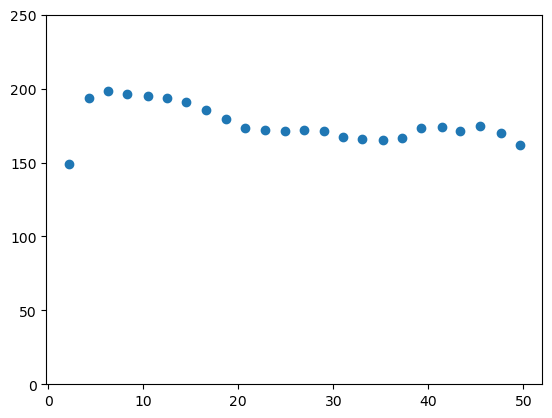

In [138]:
plt.scatter(R, V)
plt.ylim([0, 250])

In [139]:
from scipy.interpolate import CubicSpline
# x = np.linspace(0, 10, num=11)
# y = np.cos(-x**2 / 9.)
spl = CubicSpline(R, V)

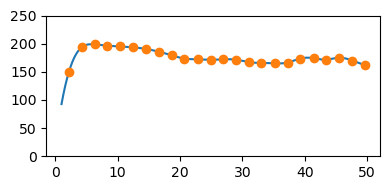

In [140]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 2))
xnew = np.linspace(1, R[-1], num=1001)
plt.plot(xnew, spl(xnew))
plt.plot(R, V, 'o', label='data')
plt.ylim([0, 250])

# ax[1].plot(xnew, spl(xnew, nu=1), '--', label='1st derivative')
# ax[2].plot(xnew, spl(xnew, nu=2), '--', label='2nd derivative')
# ax[3].plot(xnew, spl(xnew, nu=3), '--', label='3rd derivative')
# for j in range(4):
#     ax[j].legend(loc='best')
plt.tight_layout()
plt.show()

In [174]:
print(hdu.data[int(hdu.header["CRPIX1"]),int(hdu.header["CRPIX2"])])

v_0 = hdu.data[int(hdu.header["CRPIX1"]),int(hdu.header["CRPIX2"])]

-31.425231220766932


In [198]:
model_vel_map = np.empty(angle_map.shape)
model_vel_map_1 = np.empty(angle_map.shape)
incl = 31 
for i in range(model_vel_map.shape[0]):
    for j in range(model_vel_map.shape[1]):
        # print(f"spline = {spl(distance_map[i, j])}")
        model_vel_map[i, j] = spl(distance_map[i, j])/np.sin(np.radians(incl))*np.cos(np.radians(angle_map[i, j]))
        model_vel_map_1[i, j] = spl(distance_map[i, j])*np.cos(np.radians(angle_map[i, j]))


Text(0.5, 1.0, 'residual')

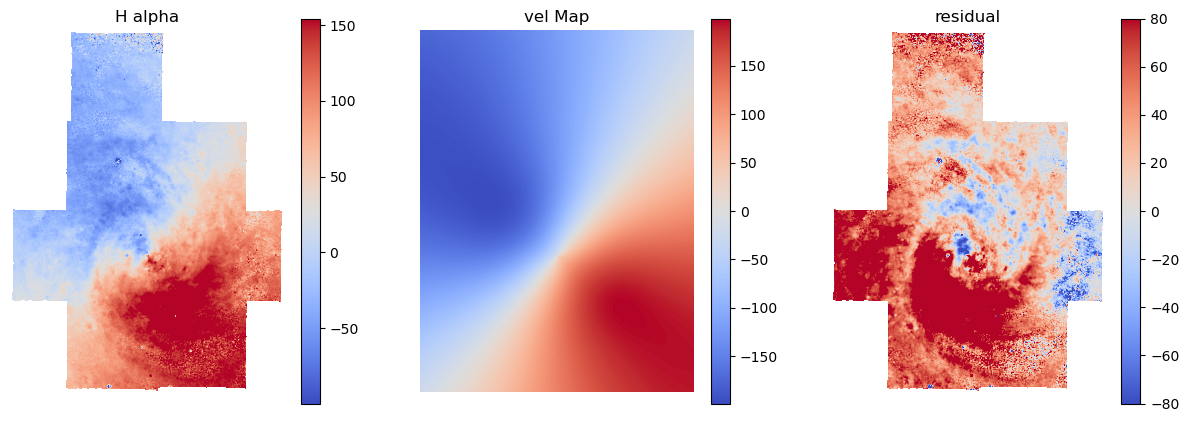

In [218]:
# Plot the model map
plt.figure(figsize=[15, 5])
plt.subplot(131)
# fig.add_subplot(121, projection=wcs)
norm=simple_norm(dataHa, "linear", percent=99.)
plt.imshow(dataHa-v_0, cmap='coolwarm', origin='lower', norm=norm)
plt.colorbar()
plt.axis("off")
plt.title("H alpha")

plt.subplot(132)
# fig.add_subplot(121, projection=wcs)
plt.imshow(model_vel_map_1, cmap='coolwarm', origin='lower')
plt.colorbar()
plt.axis("off")
plt.title("vel Map")

# palette = ListedColormap(['#2b3cce','#4c5fdd','#6b80e8','#8ca0f2','#b0c1f9','#d6e1ff','#ffd8ca','#f1b6a1','#e2957b','#d07356','#bd5133','#a82a11'])
plt.subplot(133)
# fig.add_subplot(121, projection=wcs)
resid = dataHa/np.sin(np.radians(incl)) - model_vel_map_1
norm = simple_norm(resid, "linear", percent=95)
im = plt.imshow(resid, cmap='coolwarm', origin='lower', norm = norm)
# im = plt.imshow(resid, cmap=palette, origin='lower', norm = norm)
im.set_clim(vmin=-80, vmax=80)
plt.colorbar(im)
plt.axis("off")
plt.title("residual")